<a href="https://colab.research.google.com/github/hwangtaemin/NLP-with-Disaster-Tweets/blob/main/tweet_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet/train.csv',usecols=['id','text','target'])
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet/test.csv',usecols=['id','text'])
sample_df = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet/sample_submission.csv')

In [6]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df.shape

(7613, 3)

In [9]:
!pip install text_hammer 

     |████████████████████████████████| 122kB 33.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [10]:
import text_hammer as th

In [11]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 329 µs, sys: 0 ns, total: 329 µs
Wall time: 335 µs


In [12]:
train_cleaned_df = text_preprocessing(train_df,'text')

In [13]:
train_cleaned_df[train_cleaned_df.target == 0]

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


In [14]:
train_df = train_cleaned_df.copy()

In [15]:
!pip install transformers
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

     |████████████████████████████████| 2.3MB 28.1MB/s 
     |████████████████████████████████| 3.3MB 52.0MB/s 
     |████████████████████████████████| 901kB 52.9MB/s 


Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [16]:
tokenizer('hi my name is taemin hwang ajfdkafdjakl')

{'input_ids': [101, 7632, 2026, 2171, 2003, 22297, 10020, 1044, 16600, 19128, 2546, 2094, 2912, 2546, 2094, 18317, 2140, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
print("max len of tweets",max([len(x.split()) for x in train_df.text]))
max_length = 36

max len of tweets 31


In [18]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [19]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [20]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [21]:
y_train = train_df.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [22]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [24]:
max_len = 36
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 36)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 1024)         0           tf_bert_model[0][1]          

In [26]:
optimizer = Adam(
    learning_rate=0.01,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

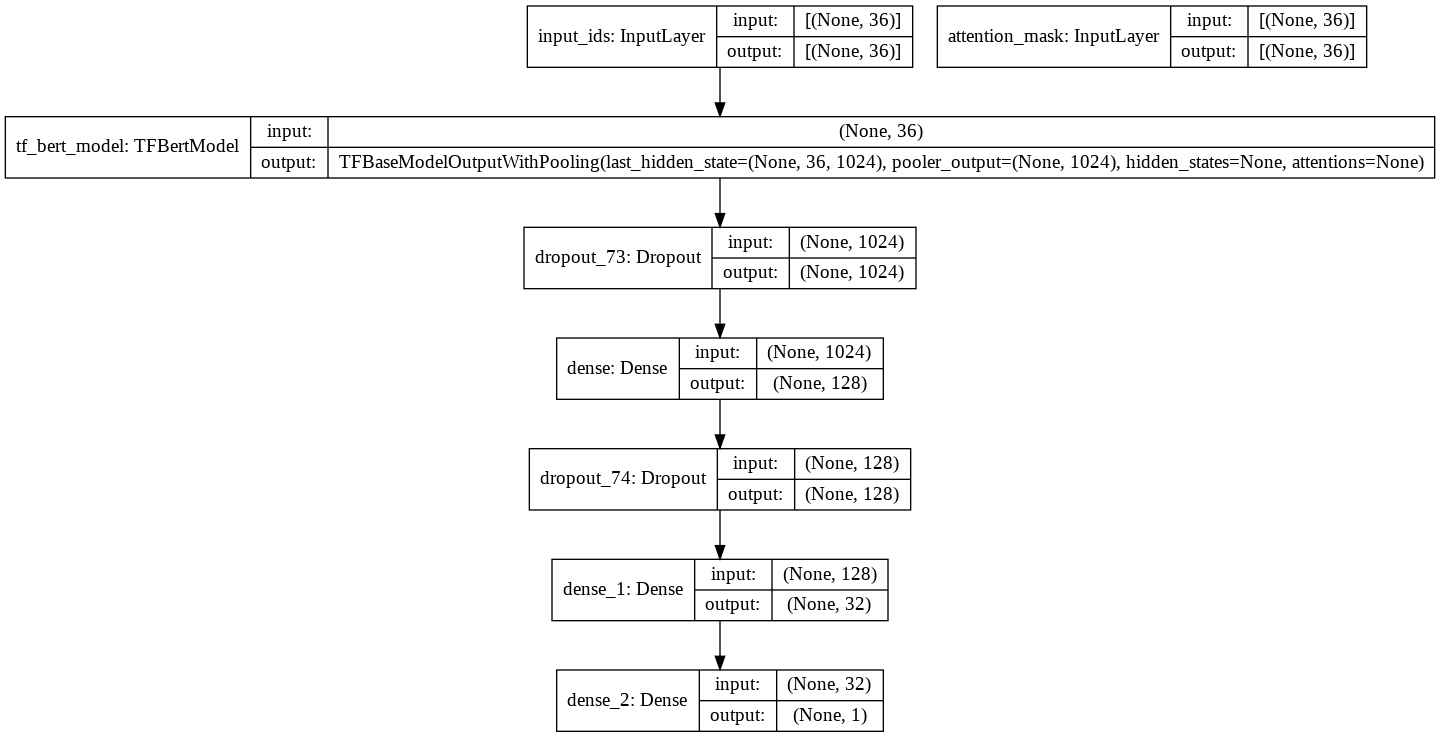

In [27]:
plot_model(model, show_shapes = True)

In [28]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#     validation_split = 0.1,
  epochs=10,
    batch_size=10
)

Epoch 1/10
762/762 [==============================] - 286s 324ms/step - loss: 0.7058 - accuracy: 0.5669
Epoch 2/10
762/762 [==============================] - 243s 319ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 3/10
762/762 [==============================] - 243s 319ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 4/10
762/762 [==============================] - 243s 319ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 5/10
762/762 [==============================] - 244s 320ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 6/10
762/762 [==============================] - 244s 321ms/step - loss: 0.6832 - accuracy: 0.5703
Epoch 7/10
762/762 [==============================] - 245s 321ms/step - loss: 0.6832 - accuracy: 0.5703
Epoch 8/10
762/762 [==============================] - 245s 321ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 9/10
762/762 [==============================] - 245s 321ms/step - loss: 0.6832 - accuracy: 0.5703
Epoch 10/10
762/762 [==============================] - 245s 321m

In [29]:
test_df

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [30]:
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [31]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [32]:
y_predicted = np.where(predicted>0.5,1,0)

In [33]:
sample_df['id'] = test_df.id
sample_df['target'] = y_predicted

In [34]:
sample_df.to_csv('submission.csv',index = False)